<a href="https://colab.research.google.com/github/ShaelinN/Multiclass-Image-Classification-on-Leaves/blob/main/LeafClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
root_dir='/content/drive/MyDrive/Final_comp702_project/'
import numpy as np

import pandas as pd
from math import log2
import os
import random

!pip install mahotas
from mahotas.features import haralick

#Segmentation and Preprocessing
in this particular dataset, images are in prime condition for segmentation, without the need for preprocessing. 

Preprocessing must be applied after segmentation in order to enhance textural features, when sharpening and detailed line drawing will not class with the requirements of the segmentation step, i.e. the requirement for less complicated shapes on the image

##Segmentation functions

###Morphological operations

In [68]:
def dilate(img,cross_size):
  SA = cv2.getStructuringElement(cv2.MORPH_CROSS,(cross_size,cross_size))
  result = cv2.dilate(img, SA)
  return result
def erode(img,cross_size):
  SA = cv2.getStructuringElement(cv2.MORPH_CROSS,(cross_size,cross_size))
  result = cv2.erode(img, SA)
  return result

###contouring functions

In [21]:
def is_significant_contour(contour, img_area, proportion_limit):
  return cv2.contourArea(contour) >= proportion_limit*img_area

def get_contours(img,refine=False, min_cutoff_contour_proportion=0.0007):
  contours,hierarchy=cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  if refine:
    #eliminate contours of background specks
    total_area = img.shape[0]*img.shape[1]
    refined = list()
    for i in range(len(contours)):
      if is_significant_contour(contours[i], total_area, min_cutoff_contour_proportion):
        refined.append(contours[i])
    return refined
  else:
    return contours

def fill_contours_on_blank(contours,original_img_shape):
  result = np.zeros(original_img_shape[:2], dtype="uint8")
  cv2.drawContours(result, contours, -1, color=[255], thickness=cv2.FILLED)
  return result



###function to get broad shapes by Canny edge detection


In [89]:
def get_outlines(img):
  mean = np.mean(img)
  std = np.std(img)
  lines = cv2.Canny(img,mean-2*std,mean+std)
  lines = dilate(lines, 3)
  return lines

###remove large objects touching image border

In [87]:
def remove_touching_edge(contour_map,original_image):#idea from leafsnap
  rect = cv2.boundingRect(original_image)
  cv2.rectangle(contour_map,rect,color=[255], thickness=cv2.LINE_8)
  contour_map = dilate(contour_map,8)

  connections = cv2.connectedComponents(contour_map)

  #cv2_imshow(connections[1]*50)

  without_clutter = np.where(connections[1]<=1,0,255).astype("uint8")

  return without_clutter

##high level segmentation function

In [88]:
def get_region_of_interest(img):
  smt = get_outlines(img)
  smt = dilate(smt,4)
  contours = get_contours(smt)
  smt = fill_contours_on_blank(contours,smt.shape)
  smt = remove_touching_edge(smt,img)
  contours = get_contours(smt,refine=True)
  smt = fill_contours_on_blank(contours,smt.shape)
  smt = erode(smt,8)
  return smt


##Preprocessing functions
preprocessing is very simple in this project, consisting of simple local histogram equalization. a canny lines to highlight the texture can also be employed, but they are not used in the final model

In [91]:
def get_enhanced_image(original_img,seg_mask):
  segmented = cv2.bitwise_and(original_img,seg_mask)
  clahe = cv2.C(clipLimit=2.0, tileGridSize=(8,8))
  return clahe.apply(segmented)

##example segmentation and preprocessing

In [92]:
lab_eucomia_ulmoides  =root_dir+'dataset/images/lab/eucommia_ulmoides/ny1152-07-3.jpg'
lab_abies_concolor = root_dir+'dataset/images/lab/abies_concolor/ny1157-02-1.jpg'
lab_gleditsia_triacanthos = root_dir + "dataset/images/lab/gleditsia_triacanthos/pi2769-05-1.jpg"
lab_acer_campestre = root_dir+ "dataset/images/lab/acer_campestre/ny1079-02-3.jpg"
lab_acer_pseudoplatanus = root_dir+ "dataset/images/lab/acer_pseudoplatanus/wb1559-03-1.jpg"


pth = lab_acer_pseudoplatanus
img = cv2.imread(pth, cv2.IMREAD_GRAYSCALE)
seg_mask = get_region_of_interest(img)
preproc = get_enhanced_image(img,seg_mask)


##Application of Segmentation

###capture the file locations for original dataset images
make the directories that dont exist

In [103]:
data_dir = "dataset/images/lab"
root_and_data = os.path.join(root_dir,data_dir)
folders = []
for item in os.listdir(root_and_data):
  item = os.path.join(item)
  folders.append(item)
files = {}

idx = 0
for i in range(len(folders)):
  this_class = folders[i]
  folder = os.path.join(root_dir, data_dir,this_class)

  for image_name in os.listdir(folder):
    original_image_path = os.path.join(data_dir,this_class,image_name)

    seg_mask_dir = os.path.join("segmentation_masks",this_class)
    final_img_dir = os.path.join("preprocessed",this_class)
    try:
      os.makedirs(os.path.join(root_dir,seg_mask_dir))
    except:
      pass
    try:
      os.makedirs(os.path.join(root_dir,final_img_dir))
    except:
      pass


    seg_mask_path = os.path.join(seg_mask_dir,image_name).replace(".jpg",".png")
    final_path = os.path.join(final_img_dir,image_name).replace(".jpg",".png")

    files[idx] = this_class, original_image_path,seg_mask_path,final_path

    idx+=1

imagesDF = pd.DataFrame.from_dict(files, orient='index',columns=['label','original_file','segmentation_mask_file','final_image_file'])
imagesDF = imagesDF.sort_values(by=['label'],ascending=True)


imagesDF.to_csv(os.path.join(root_dir,'file_list.csv'), mode='w',index=False)


###at this point, replace label with an index and create a lookup file

In [ ]:
#class name to class index alteration
imagesDF = pd.read_csv(os.path.join(root_dir,'file_list.csv'))

#give int val to each class name
class_to_ref ={imagesDF['label'][i]:i for i in range(len(imagesDF['label']))}
class_to_ref = {list(class_to_ref.keys())[i]:i for i in range(len(class_to_ref))}

ref_to_class = {item:key for key,item in class_to_ref.items()}

#replace values in dataframe
for i in range(len(imagesDF['label'])):
  imagesDF['label'][i] = class_to_ref[imagesDF['label'][i]]


imagesDF.to_csv(os.path.join(root_dir,'file_list.csv'),index=False)

title = ['class']
classFrame = pd.DataFrame.from_dict(ref_to_class, orient='index',columns=title)

classFrame.to_csv(os.path.join(root_dir,'class_id_lookup.csv'))
imagesDF.head(5)

###iteratively calculate the segmentation masks and save them

In [ ]:
# next, open each original link and calculate the mask, save to new link(mask)
num=0
start_at = 0 #if an error occurs, change start_at to be one of the last calculated images so that system can continue where it left off
imagesDF = pd.read_csv(os.path.join(root_dir,'file_list.csv'))
tot = len(imagesDF['label'])

for i in range(len(imagesDF['label'])):
  if num < start_at:
    num+=1
    continue

  im_path = os.path.join(root_dir, imagesDF['original_file'][i])
  mask_path = os.path.join(root_dir, imagesDF['segmentation_mask_file'][i])

  img = cv2.imread(im_path,cv2.IMREAD_GRAYSCALE)
  mask = get_region_of_interest(img)
  cv2.imwrite(mask_path,mask)
  #show progress
  print(num,'/',tot)    


  num+=1

###iteratively calculate final images and save them

In [ ]:
# next, open each original link and calculate the mask, save to new link(mask)
num=0
start_at = 0 #if an error occurs, change start_at to be one of the last calculated images so that system can continue where it left off
imagesDF = pd.read_csv(os.path.join(root_dir,'file_list.csv'))
tot = len(imagesDF['label'])

for i in range(len(imagesDF['label'])):
  if num < start_at:
    num+=1
    continue

  im_path = os.path.join(root_dir, imagesDF['original_file'][i])
  mask_path = os.path.join(root_dir, imagesDF['segmentation_mask_file'][i])
  fin_path = os.path.join(root_dir, imagesDF['final_image_file'][i])

  img = cv2.imread(im_path,cv2.IMREAD_GRAYSCALE)
  mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

  final = get_enhanced_image(img,mask)
  cv2.imwrite(fin_path,final)
  #show progress
  print(num,'/',tot)    


  num+=1

#Feature Extraction

###functions to calculate features

In [163]:
def get_hu_invariants(image): #ensure img is a presegmented image
  if isinstance(image,str):
    img = cv2.imread(image,cv2.IMREAD_GRAYSCALE)
  else:
    img = image
    
  img_moments = cv2.moments(img)
  Hu_moments = cv2.HuMoments(img_moments)

  #user included this step in stackoverflow
  
  Hu_moments = -np.sign(Hu_moments)*np.log10(np.abs(Hu_moments))
  
  Hu_moments = np.ndarray.flatten(Hu_moments)
  return Hu_moments

In [167]:
def get_haralick_descriptors(image):
  if isinstance(image,str):
    img = cv2.imread(image,cv2.IMREAD_GRAYSCALE)
  else:
    img = image

  haralicks = haralick(img).mean(axis=0)

  return haralicks

In [134]:
def DF_with_feature_spaces(paths_DF):
  result =  {}
  for i in range(len(path_DF['label'])):
    result[i]  = path_DF['label'][i] , path_DF['original_file'][i] ,  path_DF['segmentation_mask_file'][i] , path_DF['final_image_file'][i],'hu1','hu2','hu3','hu4','hu5','hu6','hu7','hlk1','hlk2','hlk3', 'hlk4','hlk5','hlk6','hlk7','hlk8','hlk9','hlk10','hlk11','hlk12','hlk13'
  
  
  title = ['label','original_file','segmentation_mask_file','final_image_file','hu1','hu2','hu3','hu4','hu5','hu6','hu7','hlk1','hlk2','hlk3', 'hlk4','hlk5','hlk6','hlk7','hlk8','hlk9','hlk10','hlk11','hlk12','hlk13']
  result = pd.DataFrame.from_dict(result, orient='index',columns=title,)
  return result

##Application of feature extraction

In [135]:
path_DF = pd.read_csv(os.path.join(root_dir,'file_list.csv'))
imagesDF = DF_with_feature_spaces(path_DF)

###Iteratively calculate Hu invariants per image
save after every 500 as insurance against the crashing of the runtime

In [ ]:
# next, open each original link and calculate the mask, save to new link(mask)
num=0
start_at = 0 #if an error occurs, change start_at to be the last multiple of 500 before less than the highest num printed
print_with_header = (start_at==0) #if starting anew, print header first time, else dont, its there already
first_in_batch = start_at

tot = len(imagesDF['label'])

for i in range(len(imagesDF['label'])):
  if num < start_at:
    num+=1
    continue
  
  img_path = imagesDF['final_image_file'][i]

  #get invariants    
  hu_features = get_hu_invariants(os.path.join(root_dir,img_path))
  imagesDF['hu1'][i] = hu_features[0]
  imagesDF['hu2'][i] = hu_features[1]
  imagesDF['hu3'][i] = hu_features[2]
  imagesDF['hu4'][i] = hu_features[3]
  imagesDF['hu5'][i] = hu_features[4]
  imagesDF['hu6'][i] = hu_features[5]
  imagesDF['hu7'][i] = hu_features[6]

  #periodic saving
  if num%500==0 and num!=start_at: #if not the first attempted image but is 500 images in
    #safeguard against system breaking down. occasionally write progress
    imagesDF[first_in_batch:num].to_csv(os.path.join(root_dir,'features_hu.csv'),mode='a', header=print_with_header)
    #the first time, include header, then stop
    print_with_header=False
    first_in_batch += 500
  
  num+=1
  #show progress
  print(num,'/',tot)    

imagesDF[first_in_batch:num].to_csv(os.path.join(root_dir,'features_hu.csv'), mode='a', header=print_with_header)

###Iteratively calculate Haralick features per image
save after every 500 as insurance against the crashing of the runtime

In [ ]:
# next, open each original link and calculate the mask, save to new link(mask)
num=0
start_at = 0 #if an error occurs, change start_at to be the last multiple of 500 before less than the highest num printed
print_with_header = (start_at==0) #if starting anew, print header first time, else dont, its there already
first_in_batch = start_at

imagesDF =  pd.read_csv(os.path.join(root_dir,'features_hu.csv'))
tot = len(imagesDF['label'])

for i in range(len(imagesDF['label'])):
  if num < start_at:
    num+=1
    continue
  
  img_path = imagesDF['final_image_file'][i]

  #get invariants    
  haralicks = get_haralick_descriptors(os.path.join(root_dir,img_path))
  imagesDF['hlk1'][i] = haralicks[0]
  imagesDF['hlk2'][i] = haralicks[1]
  imagesDF['hlk3'][i] = haralicks[2]
  imagesDF['hlk4'][i] = haralicks[3]
  imagesDF['hlk5'][i] = haralicks[4]
  imagesDF['hlk6'][i] = haralicks[5]
  imagesDF['hlk7'][i] = haralicks[6]  
  imagesDF['hlk8'][i] = haralicks[7]
  imagesDF['hlk9'][i] = haralicks[8]
  imagesDF['hlk10'][i] = haralicks[9]
  imagesDF['hlk11'][i] = haralicks[10]
  imagesDF['hlk12'][i] = haralicks[11]
  imagesDF['hlk13'][i] = haralicks[12]

  #periodic saving
  if num%500==0 and num!=start_at: #if not the first attempted image but is 500 images in
    #safeguard against system breaking down. occasionally write progress
    imagesDF[first_in_batch:num].to_csv(os.path.join(root_dir,'features.csv'),mode='a', header=print_with_header)
    #the first time, include header, then stop
    print_with_header=False
    first_in_batch += 500
  
  num+=1
  #show progress
  print(num,'/',tot)    

imagesDF[first_in_batch:num].to_csv(os.path.join(root_dir,'features.csv'), mode='a', header=print_with_header)

#Train test split

In [138]:
train_proportion = 0.8
test_proportion = 0.2

In [140]:
#divide and group dataset by class 
imagesDF = pd.read_csv(root_dir+'features.csv')
classFrame = pd.read_csv(root_dir+'class_id_lookup.csv')


by_class = {class_id:[] for class_id in range(len(classFrame['class']))}

for i in range(len(imagesDF.index)):
  id = imagesDF.label[i]
  #this strips the original image away. masks become directly associated with the class
  features = [
              imagesDF['segmentation_mask_file'][i] ,
              imagesDF['final_image_file'][i] ,
              imagesDF['hu1'][i] ,
              imagesDF['hu2'][i] ,
              imagesDF['hu3'][i] ,
              imagesDF['hu4'][i] ,
              imagesDF['hu5'][i] ,
              imagesDF['hu6'][i] ,
              imagesDF['hu7'][i] ,
              imagesDF['hlk1'][i] ,
              imagesDF['hlk2'][i] ,
              imagesDF['hlk3'][i] ,
              imagesDF['hlk4'][i] ,
              imagesDF['hlk5'][i] ,
              imagesDF['hlk6'][i] ,
              imagesDF['hlk7'][i] ,
              imagesDF['hlk8'][i] ,
              imagesDF['hlk9'][i] ,
              imagesDF['hlk10'][i] ,
              imagesDF['hlk11'][i] ,
              imagesDF['hlk12'][i] ,
              imagesDF['hlk13'][i] ,
              
              ]

  by_class[id].append(features)


In [142]:
by_class_tr = {}
by_class_te = {}
tr_pos,te_pos = 0,0

for class_id, all_features in by_class.items():
  #for each class, shuffle the items
  random.shuffle(all_features)
  idx = 0

  #pick as many items off the top to satisfy the train proportion
  while idx/len(all_features) <= train_proportion:
    by_class_tr[tr_pos] = [class_id] #class id is first element in list
    #ensure a flat list with class id and feature vals so pd.dataframe doesn't freak out
    for item in all_features[idx]:
      by_class_tr[tr_pos].append(item) #append the features into the array      
    tr_pos +=1
    idx+=1

  #pick the rest as training set
  while idx < len(all_features):
    by_class_te[te_pos] = [class_id]
    for item in all_features[idx]:
      by_class_te[te_pos].append(item)
    te_pos +=1
    idx+=1


In [144]:
def clean_and_save_csv(data_dict,purpose="train"):
  title = ['class_id','segmentation_mask_file','final_image_file','hu1','hu2','hu3','hu4','hu5','hu6','hu7','hlk1','hlk2','hlk3','hlk4','hlk5','hlk6','hlk7','hlk8','hlk9','hlk10','hlk11','hlk12','hlk13']
  DF = pd.DataFrame.from_dict(data_dict, orient='index',columns=title)
  #drop any nans present in data
  DF = DF.dropna(subset=['hu1','hu2','hu3','hu4','hu5','hu6','hu7','hlk1','hlk2','hlk3','hlk4','hlk5','hlk6','hlk7','hlk8','hlk9','hlk10','hlk11','hlk12','hlk13'])

  #shuffle the DF
  DF = DF.reindex(np.random.permutation(DF.index))
  DF.reset_index(inplace=True,drop=True)

  #save
  file_name = purpose+'.csv'
  DF.to_csv(os.path.join(root_dir,'split_by_purpose/',file_name), index=False)




In [146]:
try:
  os.mkdir(os.path.join(root_dir,'split_by_purpose/'))
except:
  pass

clean_and_save_csv(by_class_tr,"train")
clean_and_save_csv(by_class_te,"test")

#Model Definition

In [147]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 22.3MB 1.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [148]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [180]:
model_RFC = RandomForestClassifier(n_estimators=200)
model_KNN = KNeighborsClassifier(n_neighbors=1) 
model_DT = DecisionTreeClassifier()
model_MLP = MLPClassifier(max_iter=1100, verbose=True) 

model = model_RFC

#Training

In [150]:
train = pd.read_csv(os.path.join(root_dir,'split_by_purpose/','train.csv'))
x_train = train.loc[1:,'hu1':'hlk13']
y_train = train.loc[1:,'class_id':'class_id']
y_train = np.ravel(y_train)

In [ ]:
model.fit(x_train, y_train)

#Evaluation

In [152]:
from sklearn.metrics import top_k_accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn;seaborn.set()

In [153]:
test = pd.read_csv(os.path.join(root_dir,'split_by_purpose/','test.csv'))
x_test = test.loc[1:,'hu1':'hlk13']
y_test = test.loc[1:,'class_id':'class_id']
y_test = np.ravel(y_test)

In [182]:
y_pred = model.predict_proba(x_test)
top_k_accuracy_score(y_test,y_pred,k=5)

0.597228532485234

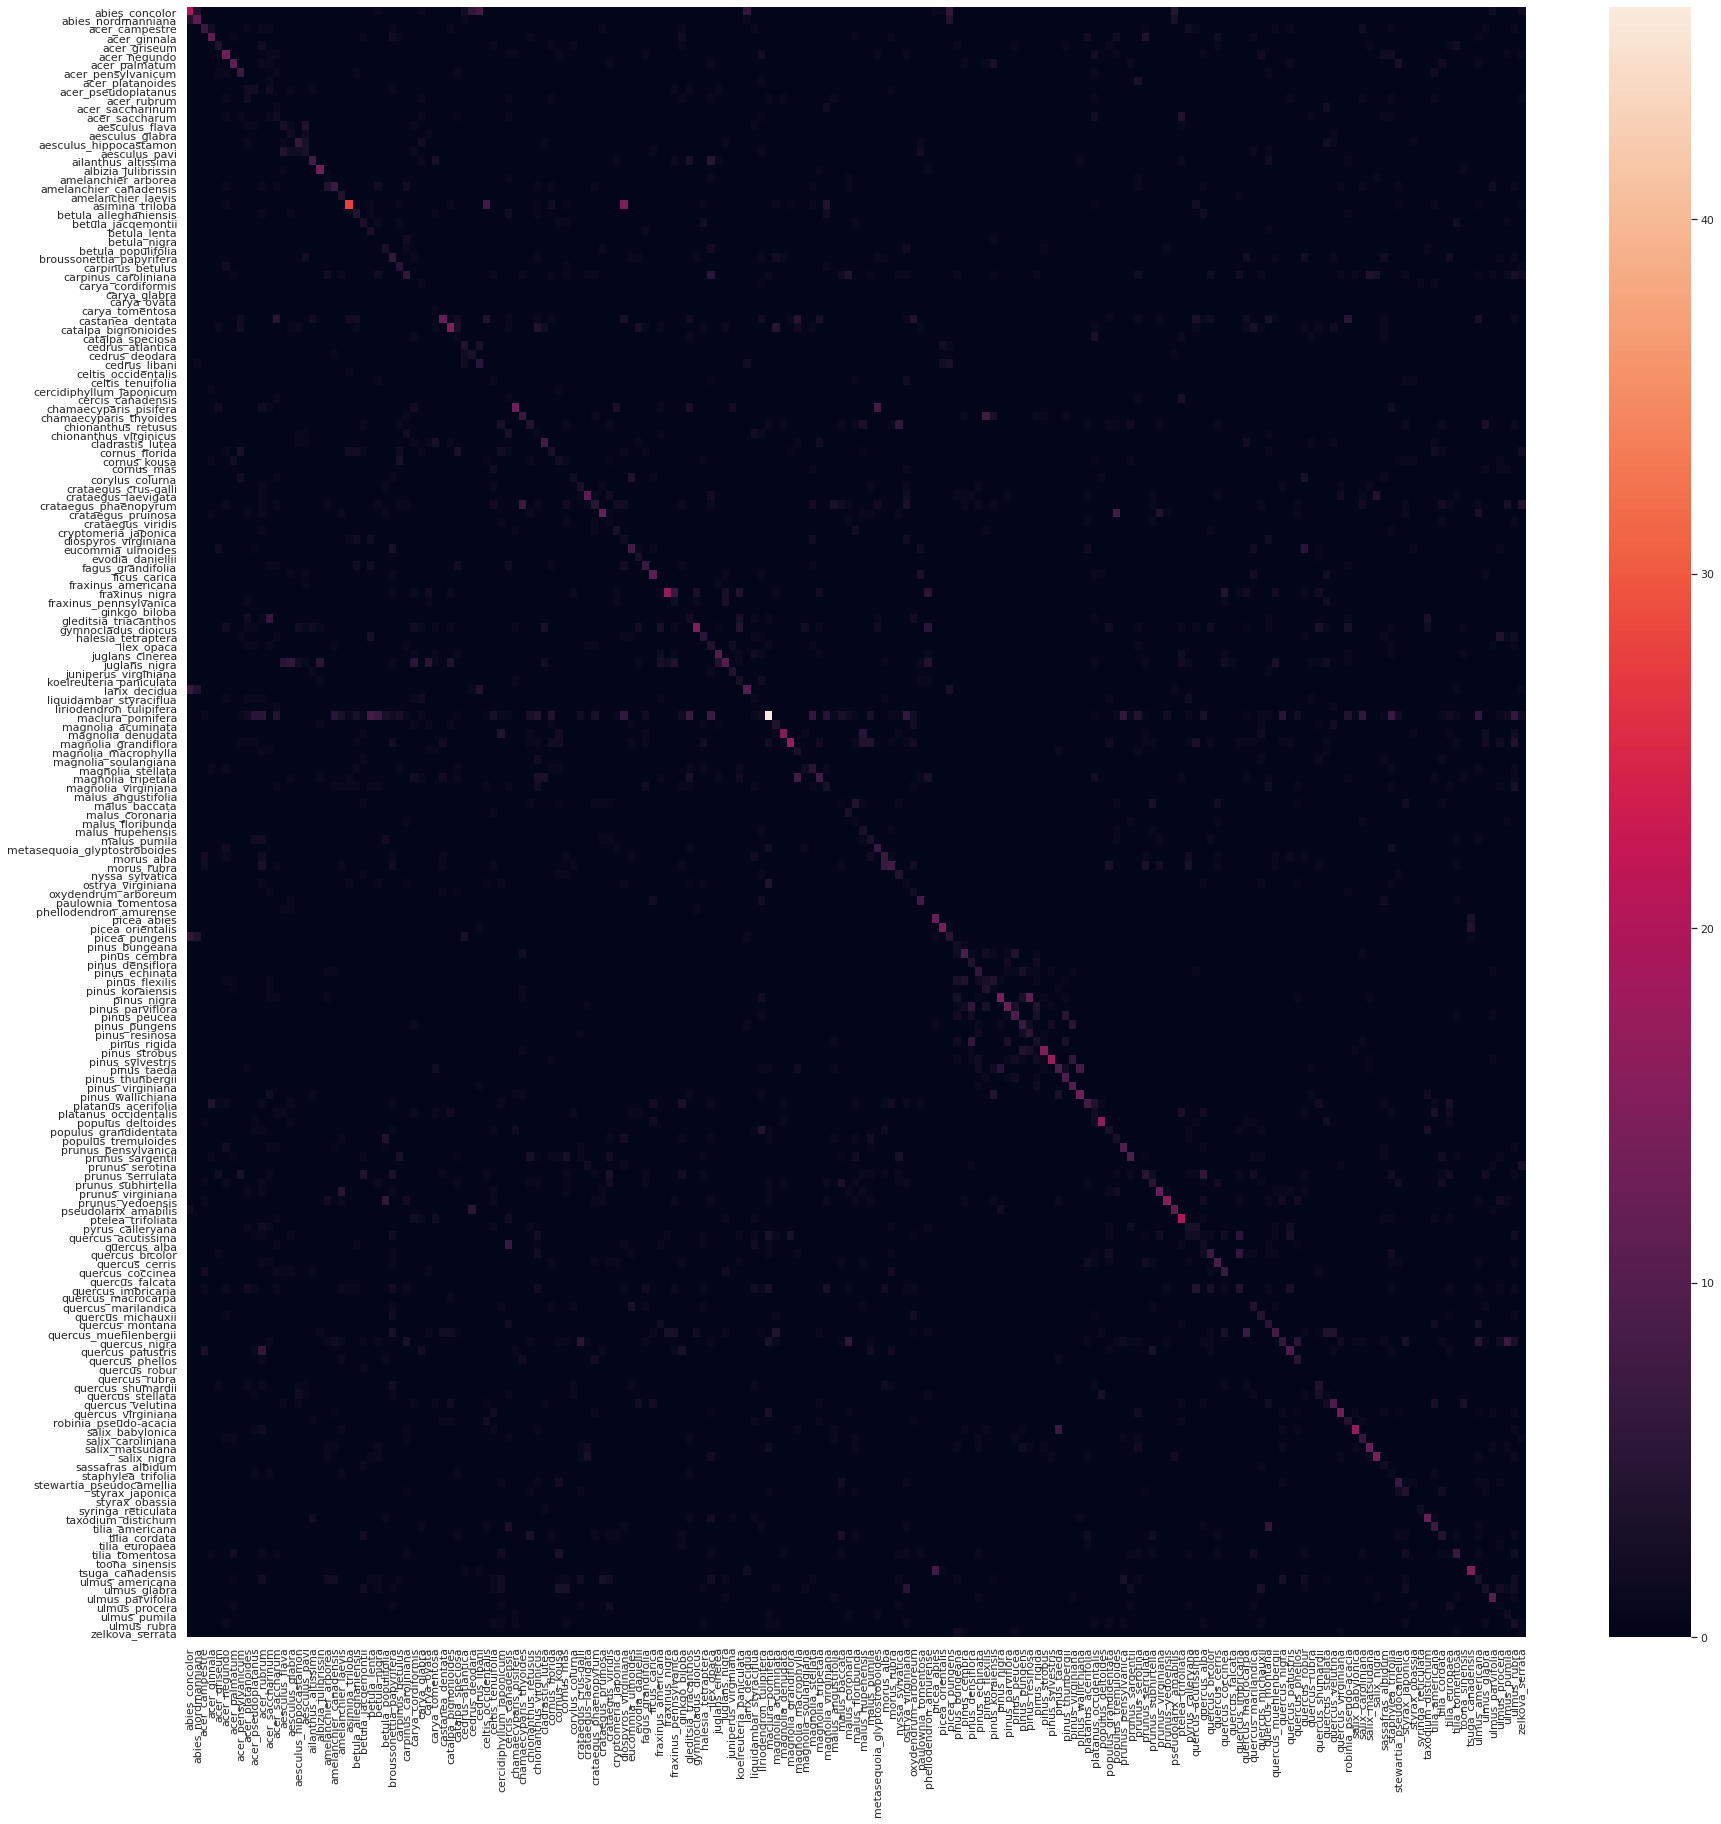

In [183]:
y_pred = model.predict(x_test)
cnf_mtx = confusion_matrix(y_test,y_pred)

labels = np.array(pd.read_csv(root_dir+"class_id_lookup.csv")["class"])
plt.subplots(figsize = (30,30))

hmp = seaborn.heatmap(cnf_mtx.T,xticklabels = labels, yticklabels=labels)

#Outward facing function

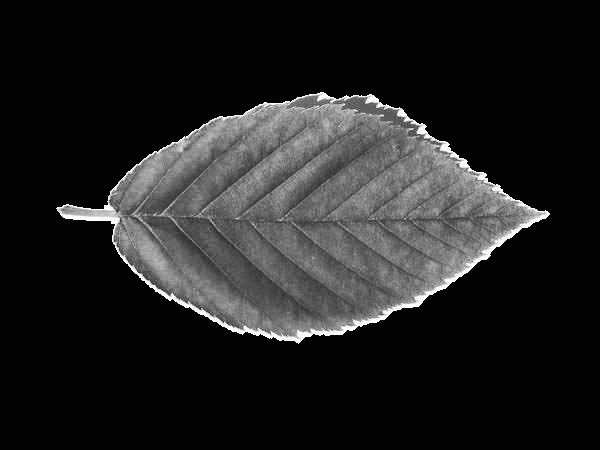

     class_prob          class_name
87        0.185  magnolia_tripetala
176       0.140      toona_sinensis
49        0.105    cladrastis_lutea
34        0.090     carya_tomentosa
73        0.065     juglans_cinerea


In [179]:
def classify(leaf_path,model): #assumes quality of photo is sufficient

  img = cv2.imread(leaf_path,cv2.IMREAD_GRAYSCALE)

  #perform identical preprocessing and segmentation
  mask = get_region_of_interest(img)
  segmentation = get_enhanced_image(img,mask)
  cv2_imshow(segmentation)

  #get features

  hu = [i for i in get_hu_invariants(segmentation)]
  hlk = [i for i in get_haralick_descriptors(segmentation)]

  features = hu+hlk

  #make predictions
  try:
    proba = model.predict_proba([features])
  except:
    print("that didn't work. please use images of proportions comparable to 800x600")

  #rank predictions and display top 5
  data = {}
  categories = np.array(pd.read_csv(root_dir+"class_id_lookup.csv")["class"])

  for i in range(len(proba[0])):
    data[i] = proba[0][i],categories[i]

  result = pd.DataFrame.from_dict(data, orient='index',columns=['class_prob','class_name'])


  result = result.sort_values(by=['class_prob'],ascending=False)

  print(result.head(5))

classify("trial2.jpg",model)